In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
sns.set()

In [2]:
ls ../save_models

cache_data/  codebert/  summarize/  summarize#summarize/  train.log


In [3]:
pth = '../save_models/summarize/'

In [4]:
lang, model = 'java/', 'codet5'  # codebert roberta graphcodebert codet5

In [5]:
data_path = pth + lang  + model + "/" + 'cache_data/'

In [6]:
data_path = '../'

# read run_att_all_result.txt

'../run_att_all_result.txt'

In [45]:
model_full_name={'roberta':'RoBERTa',"codebert":'CodeBERT','graphcodebert':'GraphCodeBERT','unixcoder':'UniXcoder'}
model_full_name_reverse=dict([value,key] for key,value in model_full_name.items())
language_full_name={'go':'Go','java':'Java','javascript':'JavaScript','python':'Python'}
language_full_name_reverse=dict([value,key] for key,value in language_full_name.items())
score_df=pd.DataFrame(columns=['language', 'model','layer',"score"])
with open(os.path.join(data_path,"score_per_head_220622.txt"),"r",encoding="utf-8") as f:
    # for i in range(10):
    #     f.write(f"您好世界:{i}\n")
    # print(f.readlines())
    for line in f.readlines():
        #"0 roberta summarize go 0.49764030289388".split(" ")
        res=line.split(" ")
        layer_num=int(res[0])
        model=model_full_name[res[1]]
        language=language_full_name[res[3]]
        score=float(res[4])
        if layer_num==-1:
            continue
        
        score_df=score_df.append({'language': language,"model":model,"layer":layer_num,"score":score}, ignore_index=True)

In [46]:
score_df

,language,model,layer,score
0,Go,RoBERTa,0,0.506785
1,Go,RoBERTa,1,0.402844
2,Go,RoBERTa,2,0.454899
3,Go,RoBERTa,3,0.429364
4,Go,RoBERTa,4,0.421166
...,...,...,...,...
187,Python,UniXcoder,7,0.251368
188,Python,UniXcoder,8,0.216442
189,Python,UniXcoder,9,0.217301
190,Python,UniXcoder,10,0.209893


In [47]:
score_last_layer=pd.DataFrame(index=score_df['model'].unique(),columns=score_df['language'].unique())
for index,row in score_df[score_df['layer']==11].iterrows():
    score_last_layer.at[row['model'],row['language']]=row['score']
score_last_layer

,Go,Java,JavaScript,Python
RoBERTa,0.395784,0.238644,0.184804,0.20533
CodeBERT,0.409738,0.307961,0.229409,0.223956
GraphCodeBERT,0.427761,0.308069,0.267955,0.234928
UniXcoder,0.35175,0.230939,0.21858,0.188656


In [48]:
score_best_bleu=pd.DataFrame(index=score_df['model'].unique(),columns=score_df['language'].unique())
score_best_ppl=pd.DataFrame(index=score_df['model'].unique(),columns=score_df['language'].unique())
pth = '../save_models/summarize/'
for lang in score_df['language'].unique():
    for model in score_df['model'].unique():
        trainlog_path= pth + language_full_name_reverse[lang] + "/" + model_full_name_reverse[model] + "/" + 'train.log'
        with open(trainlog_path,'r') as f:
            for line in f.readlines():
                if "[best-ppl] bleu-4" in line:
                    left_piece=line.find("[best-ppl] bleu-4")+19
                    right_piece=line.find(", em:")
                    score_best_ppl.at[model,lang]=float(line[left_piece:right_piece])
                if "[best-bleu] bleu-4" in line:
                    left_piece=line.find("[best-bleu] bleu-4")+20
                    right_piece=line.find(", em:")
                    score_best_bleu.at[model,lang]=float(line[left_piece:right_piece])

In [49]:
score_best_bleu

,Go,Java,JavaScript,Python
RoBERTa,17.66,17.6,12.94,18.28
CodeBERT,18.1,18.75,13.89,19.2
GraphCodeBERT,18.52,19.31,14.36,19.31
UniXcoder,18.57,19.21,14.62,19.65


In [50]:
score_best_ppl

,Go,Java,JavaScript,Python
RoBERTa,17.62,17.6,12.36,18.28
CodeBERT,18.06,18.55,13.38,19.02
GraphCodeBERT,18.41,19.24,14.21,19.24
UniXcoder,18.45,19.16,14.09,19.48


In [51]:
score_all=pd.DataFrame(columns=['model','language','score','from'])
for model,row in score_last_layer.iterrows():
    for language,score in row.items():
        score_all=score_all.append({"model":model,'language': language,"score":float(score),'from':'score'}, ignore_index=True)
for model,row in score_best_bleu.iterrows():
    for language,score in row.items():
        score_all=score_all.append({"model":model,'language': language,"score":float(score),'from':'best_bleu'}, ignore_index=True)
for model,row in score_best_ppl.iterrows():
    for language,score in row.items():
        score_all=score_all.append({"model":model,'language': language,"score":float(score),'from':'best_ppl'}, ignore_index=True)
score_all.tail()

,model,language,score,from
43,GraphCodeBERT,Python,19.24,best_ppl
44,UniXcoder,Go,18.45,best_ppl
45,UniXcoder,Java,19.16,best_ppl
46,UniXcoder,JavaScript,14.09,best_ppl
47,UniXcoder,Python,19.48,best_ppl


In [18]:
def first_order_difference(score_all_new_go_):
    score_all_new_dif=score_all_new_go_.T.copy()
    i=0
    for index,row in score_all_new_dif.iterrows():

        if i==0:
            old_row=row
            i+=1
            continue
        new_row=row.copy()
    #     if i==2:
    #         print(new_row,old_row)
        score_all_new_dif.loc[index]=new_row-old_row
        old_row=new_row
        i+=1
    return score_all_new_dif.T

              score(scale) best_bleu best_ppl
roberta            17.3984  0.261586    -0.04
codebert           17.9674  0.132622    -0.04
graphcodebert      18.8189 -0.298898    -0.11
              score(scale) best_bleu best_ppl
roberta            17.4084   0.19162        0
codebert           18.0895  0.660543     -0.2
graphcodebert      19.3323 -0.232314    -0.32
              score(scale) best_bleu best_ppl
roberta            12.8322  0.107828    -0.58
codebert           13.5244  0.365635    -0.51
graphcodebert      16.1815  -1.82154    -0.15
              score(scale)  best_bleu best_ppl
roberta            18.2438  0.0362017        0
codebert           16.6225    2.57746    -0.18
graphcodebert      19.2317  0.0783209    -0.07


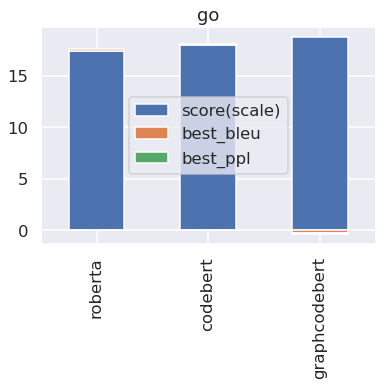

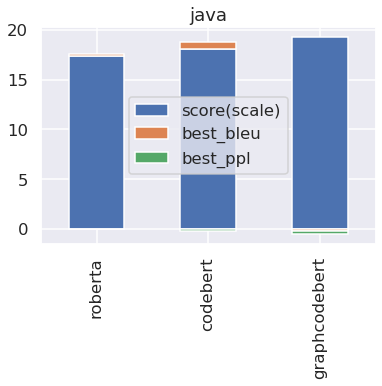

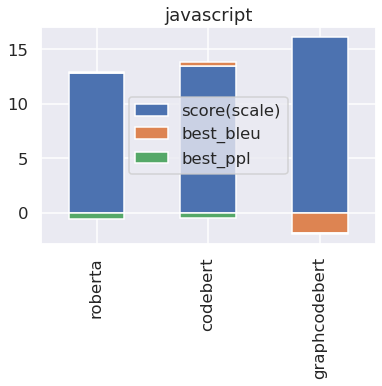

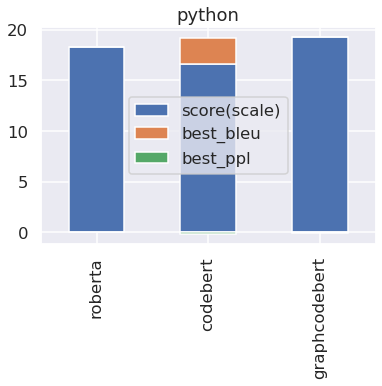

In [232]:
i=1
for language in score_df['language'].unique(): 
    score_all_new_go=pd.DataFrame()
    scale={'go':44,'java':70,'javascript':61,'python':78}
    score_all_new_go['score(scale)']=score_last_layer[language]*scale[language]
    score_all_new_go['best_bleu']=score_best_bleu[language]
    score_all_new_go['best_ppl']=score_best_ppl[language]
    print(first_order_difference(score_all_new_go))
    first_order_difference(score_all_new_go).plot(kind='bar', stacked=True)
    plt.title(language)
    i+=1


[(16.0, 20.0)]

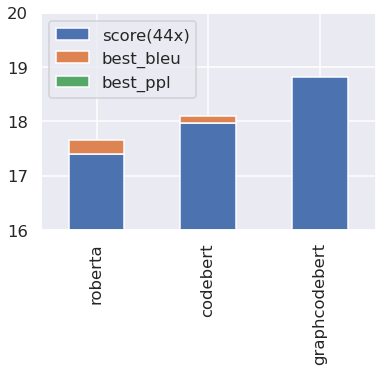

In [201]:
score_all_new_dif.T.plot(kind='bar', stacked=True).set(ylim=(16,20)).title('go')

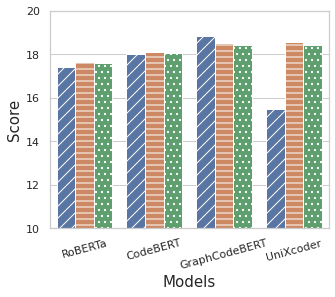

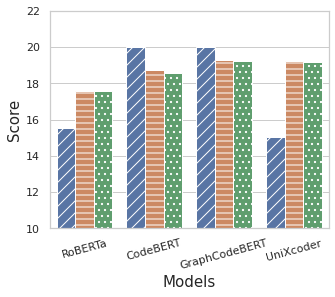

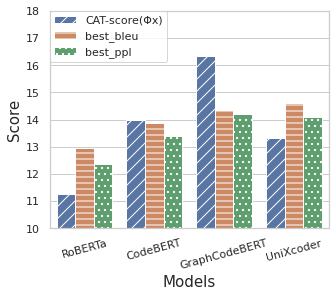

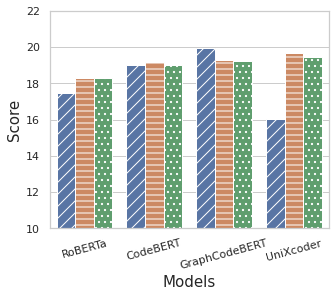

In [139]:
i=1
#plt.figure(figsize=(15,2.5))
for language in score_df['language'].unique(): 
    plt.figure(figsize=(5,4))
    score_all_copy=score_all.copy()
    score_all_copy=score_all_copy[score_all_copy['language']==language]
    scale={'Go':44,'Java':65,'JavaScript':61,'Python':85}
    for index,row in score_all_copy.iterrows():
        if row['from']=='score':
            score_all_copy.at[index,'score']*=scale[language]
            score_all_copy.at[index,'from']='CAT-score(Φx)'
#     score_all_copy=score_all_copy.rename(columns={"score":'score('+str(scale[language])+'x)'})
#     print(score_all_copy)
    #plt.subplot(1,4,i)
    #plt.subplots_adjust(wspace=0.5,hspace=0.5)
    with sns.axes_style("whitegrid"):
        p=sns.barplot(
            data=score_all_copy,
            x='model',
            y='score',
            hue='from'
        )
        hatches=['//']*4+['--']*4+['..']*4
        for patch_i,thisbar in enumerate(p.patches):
            thisbar.set_hatch(hatches[patch_i])
        plt.legend(loc='upper left', borderaxespad=0)
        if i!=3:
            p.get_legend().remove()
        plt.xticks(rotation=15)
        p.set_xlabel('Models',fontsize=15)
        p.set_ylabel('Score',fontsize=15)
        #lim_scale={"go":(17,20),'java':(17,20),'javascript':(12,17),'python':(16,20)}
        lim_scale={"Go":(10,20),'Java':(10,22),'JavaScript':(10,18),'Python':(10,22)}
        plt.ylim(lim_scale[language])
        #plt.title(language)
        i+=1
        plt.savefig('../'+'score_bleu_barplot_'+language+'_'+str(scale[language])+'x'+'.pdf',dpi=300, format="pdf", bbox_inches="tight")

        plt.show()

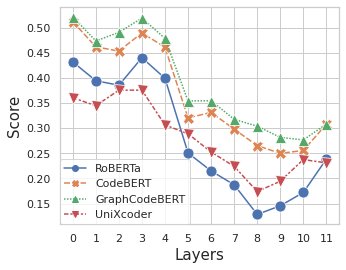

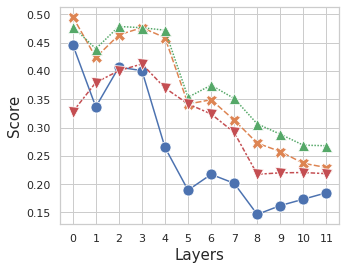

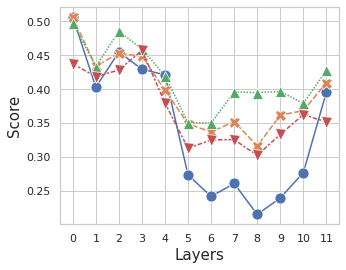

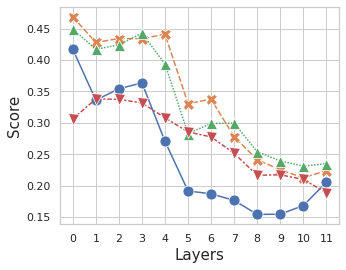

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.datasets import load_diabetes
from matplotlib.ticker import MultipleLocator,FormatStrFormatter

#java
plt.figure(figsize=(5,4))
df=score_df[score_df['language']=='Java']
# plt.subplot(1,4,1)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
with sns.axes_style("whitegrid"):
    p=sns.lineplot(x="layer", y="score", hue="model",data=df,style="model",markers=['o','X','^','v'],markersize=11)
    plt.legend(loc='lower left',borderaxespad=0)
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    p.set_xlabel('Layers',fontsize=15)
    p.set_ylabel('Score',fontsize=15)
    # plt.title('Score Each Layer'+' (Java)')
    plt.savefig('../'+'score_each_layer'+'_Java'+'.pdf', dpi=300, format="pdf", bbox_inches="tight")
    plt.show()

#javascript
plt.figure(figsize=(5,4))
df=score_df[score_df['language']=='JavaScript']
# plt.subplot(1,4,2)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
with sns.axes_style("whitegrid"):
    p=sns.lineplot(x="layer", y="score", hue="model",data=df,style="model",markers=['o','X','^','v'],markersize=11)
    p.get_legend().remove()
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    p.set_xlabel('Layers',fontsize=15)
    p.set_ylabel('Score',fontsize=15)
    # plt.title('Score Each Layer (JavaScript)')
    plt.savefig('../'+'score_each_layer'+'_JavaScript'+'.pdf', dpi=300, format="pdf", bbox_inches="tight")
    plt.show()

#go
plt.figure(figsize=(5,4))
df=score_df[score_df['language']=='Go']
# plt.subplot(1,4,3)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
with sns.axes_style("whitegrid"):
    p=sns.lineplot(x="layer", y="score", hue="model",data=df,style="model",markers=['o','X','^','v'],markersize=11)
    p.get_legend().remove()
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    p.set_xlabel('Layers',fontsize=15)
    p.set_ylabel('Score',fontsize=15)
    
    # plt.title('Score Each Layer (Go)')
    plt.savefig('../'+'score_each_layer'+'_Go'+'.pdf', dpi=300, format="pdf", bbox_inches="tight")
    plt.show()

#python
plt.figure(figsize=(5,4))
df=score_df[score_df['language']=='Python']
# plt.subplot(1,4,4)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
with sns.axes_style("whitegrid"):
    p=sns.lineplot(x="layer", y="score", hue="model",data=df,style="model",markers=['o','X','^','v'],markersize=11)
    p.get_legend().remove()
    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    p.set_xlabel('Layers',fontsize=15)
    p.set_ylabel('Score',fontsize=15)
    
    # plt.title('Score Each Layer (Python)')
    plt.savefig('../'+'score_each_layer'+'_Python'+'.pdf', dpi=300, format="pdf", bbox_inches="tight")
    plt.show()

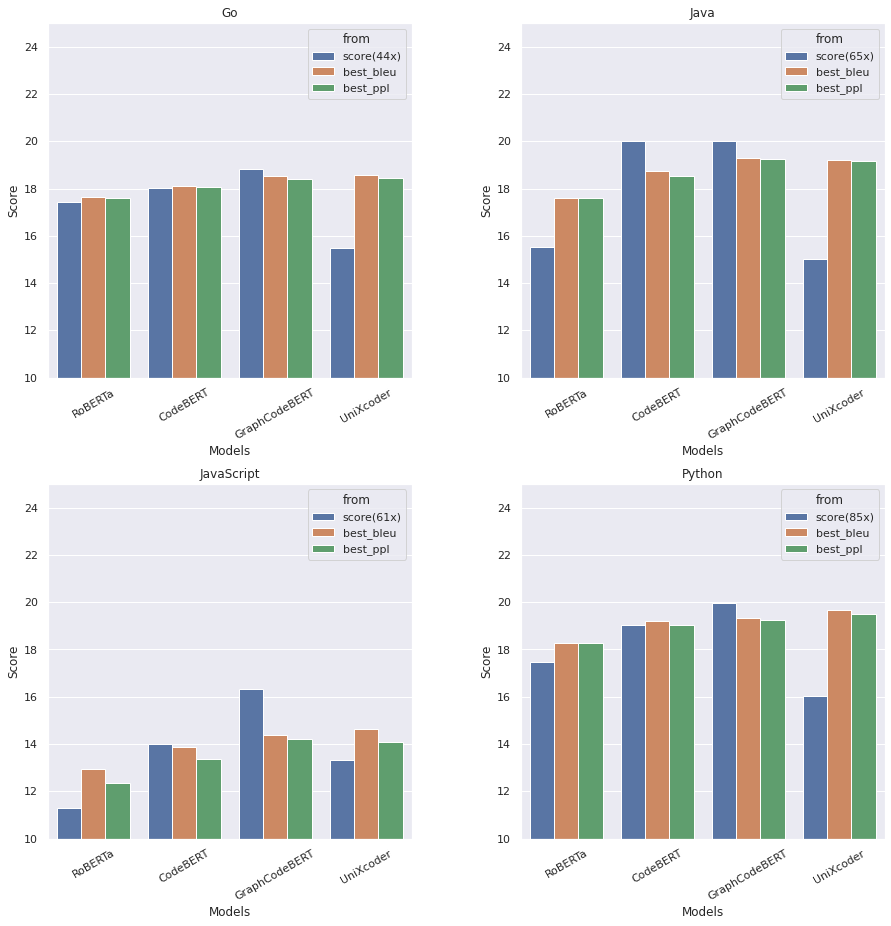

In [84]:
i=1
plt.figure(figsize=(15,15))
for language in score_df['language'].unique(): 
    score_all_copy=score_all.copy()
    score_all_copy=score_all_copy[score_all_copy['language']==language]
    scale={'Go':44,'Java':65,'JavaScript':61,'Python':85}
    for index,row in score_all_copy.iterrows():
        if row['from']=='score':
            score_all_copy.at[index,'score']*=scale[language]
            score_all_copy.at[index,'from']='score('+str(scale[language])+'x)'
#     score_all_copy=score_all_copy.rename(columns={"score":'score('+str(scale[language])+'x)'})
#     print(score_all_copy)
    plt.subplot(2,2,i)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    p=sns.barplot(
        data=score_all_copy,
        x='model',
        y='score',
        hue='from'
    )
    plt.xticks(rotation=30)
    p.set_xlabel('Models')
    p.set_ylabel('Score')
    #lim_scale={"go":(17,20),'java':(17,20),'javascript':(12,17),'python':(16,20)}
    lim_scale={"Go":(10,25),'Java':(10,25),'JavaScript':(10,25),'Python':(10,25)}
    plt.ylim(lim_scale[language])
    plt.title(language)
    i+=1
plt.savefig('../'+'score_bleu_barplot_horizon'+'.pdf',dpi=300, format="pdf", bbox_inches="tight")

plt.show()

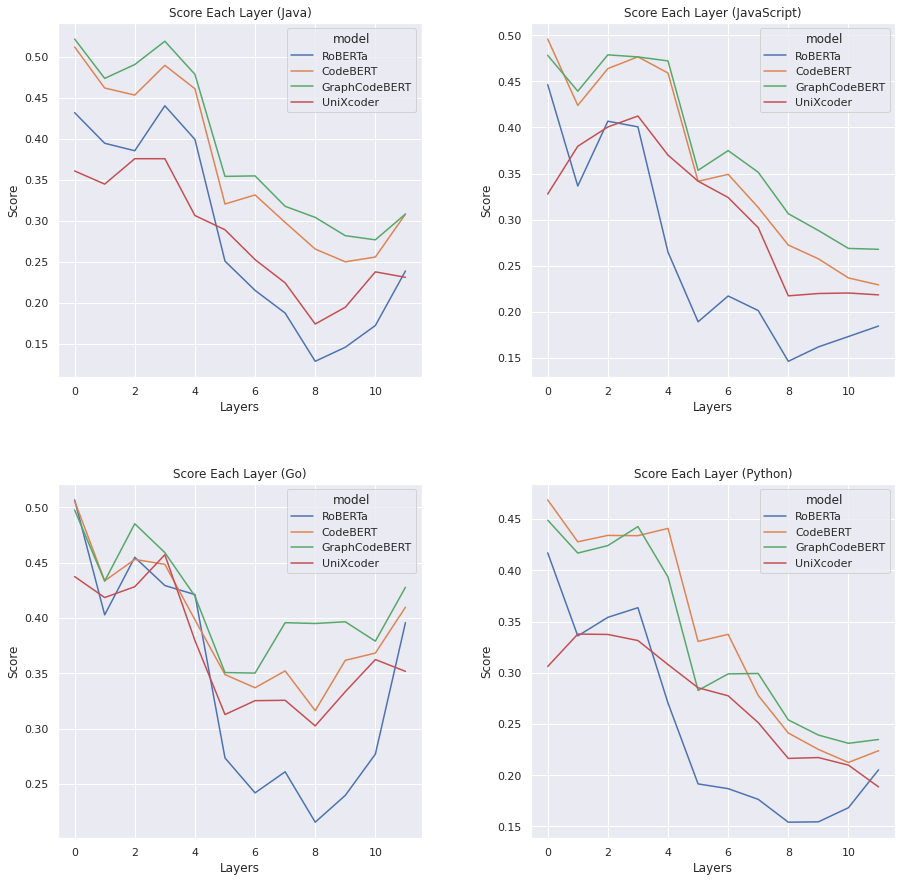

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.datasets import load_diabetes

plt.figure(figsize=(15,15))
#java
df=score_df[score_df['language']=='Java']
plt.subplot(2,2,1)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
p=sns.lineplot(x="layer", y="score", hue="model",data=df)
p.set_xlabel('Layers')
p.set_ylabel('Score')
plt.title('Score Each Layer'+' (Java)')
#javascript
df=score_df[score_df['language']=='JavaScript']
plt.subplot(2,2,2)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
p=sns.lineplot(x="layer", y="score", hue="model",data=df)
p.set_xlabel('Layers')
p.set_ylabel('Score')
plt.title('Score Each Layer (JavaScript)')

#go
df=score_df[score_df['language']=='Go']
plt.subplot(2,2,3)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
p=sns.lineplot(x="layer", y="score", hue="model",data=df)
p.set_xlabel('Layers')
p.set_ylabel('Score')
plt.title('Score Each Layer (Go)')

#python
df=score_df[score_df['language']=='Python']
plt.subplot(2,2,4)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
p=sns.lineplot(x="layer", y="score", hue="model",data=df)
p.set_xlabel('Layers')
p.set_ylabel('Score')
plt.title('Score Each Layer (Python)')
plt.savefig('../'+'score_each_layer_horizon.pdf', dpi=300, format="pdf", bbox_inches="tight")

plt.show()